/var/folders/kj/gtc9bnbd25j7_j7tyky5yl2c0000gn/T/ipykernel_22665/1872122150.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/var/folders/kj/gtc9bnbd25j7_j7tyky5yl2c0000gn/T/ipykernel_22665/1872122150.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


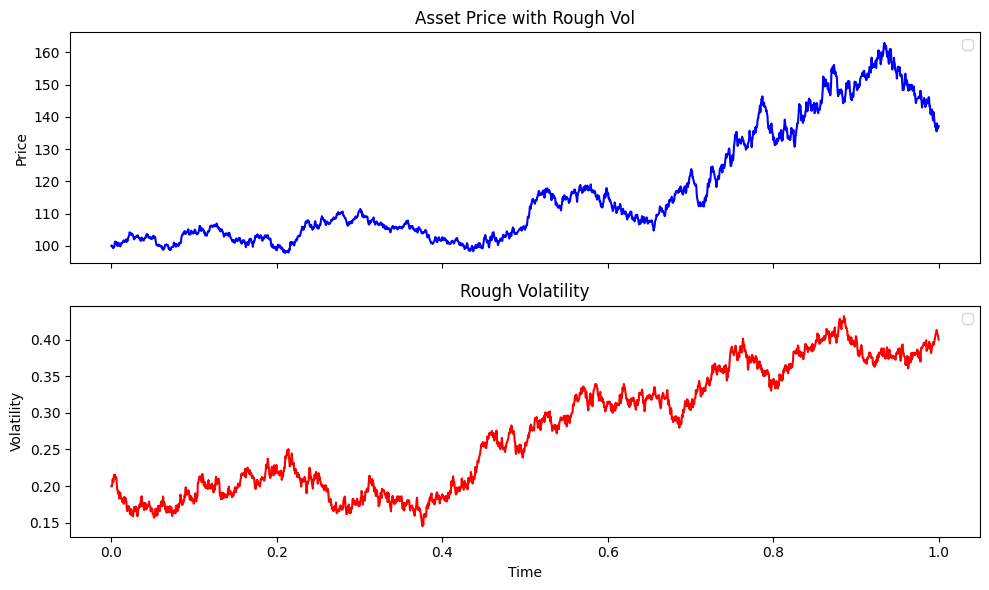

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def generate_fbm(H, N, T=1.0, seed=42, eps=1e-14):
    """
    生成分数布朗运动 (fractional Brownian motion) 样本序列。
    
    参数：
    ---------
    H    : Hurst 指数 (0 < H < 1)
    N    : 时间步数（离散点数 - 1）
    T    : 总模拟时长
    seed : 随机种子，便于复现
    eps  : 对角线修正项
    
    返回：
    ---------
    times: 时间序列 [0, T]
    fbm  : 对应时间点的 fBM 值 (长度 N+1)，其中 fbm[0] = 0
    """
    # 如果 H 不在 (0,1) 范围内，尽早抛出错误或警告
    if H <= 0 or H >= 1:
        raise ValueError("Hurst parameter H must be in (0, 1).")
    
    np.random.seed(seed)
    dt = T / N
    # 时间点
    times = np.linspace(0, T, N+1)
    
    # 协方差矩阵的构造: Cov(X(t_i), X(t_j)) = 0.5*(t_i^{2H} + t_j^{2H} - |t_i - t_j|^{2H})
    t_power = times**(2*H)
    cov = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(N+1):
            cov[i, j] = 0.5 * (t_power[i] + t_power[j] - abs(times[i] - times[j])**(2*H))
    
    # 加上对角线修正
    cov += eps * np.eye(N+1)
    
    # Cholesky 分解
    L = np.linalg.cholesky(cov)
    
    # 生成标准正态向量
    z = np.random.randn(N+1)
    
    # 计算 fBM
    fbm = L @ z
    
    return times, fbm


def simulate_rough_vol_bs(H=0.4, N=1000, T=1.0, r=0.0, 
                          S0=100.0, sigma0=0.2, alpha=0.1, seed=42):
    """
    使用分数布朗运动作为驱动的粗糙波动率, 模拟 Black–Scholes 资产价格时间序列。
    
    参数：
    ---------
    H      : Hurst 指数，控制 fBM 的“粗糙”程度 (H < 0.5 时波动率更“rough”)
    N      : 离散步数
    T      : 总时间长度
    r      : 无风险利率
    S0     : 初始资产价格
    sigma0 : 基准波动率（常数项）
    alpha  : fBM 波动率放大系数
    seed   : 随机数种子
    
    返回：
    ---------
    times: 时间序列
    S    : 模拟出的资产价格序列
    sigma: 对应每个时间点的波动率序列
    """
    # 1. 生成 fBM 序列
    times, fbm = generate_fbm(H, N, T, seed=seed, eps=1e-14)
    
    # 2. 定义波动率序列 (rough volatility)
    #    例如: sigma(t) = sigma0 + alpha * X_t
    #    如果不希望出现负值，可以改成 exp() 或者截断等方式。
    sigma = sigma0 + alpha * fbm
    
    # 3. 基于欧拉离散 (对数形式) 模拟资产价格
    dt = T / N
    S = np.zeros(N+1)
    S[0] = S0
    
    # 初始化随机数（标准正态）
    np.random.seed(seed+1)  # 与 fBM 的生成种子区分
    Z = np.random.randn(N)
    
    for i in range(N):
        # 如果这里考虑到 sigma[i] 可能为负，可做截断:
        sig_i = max(sigma[i], 1e-16)
        
        S[i+1] = S[i] * np.exp((r - 0.5 * sig_i**2)*dt + sig_i * np.sqrt(dt) * Z[i])
    
    return times, S, sigma


def main():
    # 模拟参数
    H = 0.4        # Hurst 指数（< 0.5 表示更具"rough"特性）
    N = 2000       # 步数
    T = 1.0        # 总时长
    r = 0.05       # 无风险利率
    S0 = 100.0     # 初始价格
    sigma0 = 0.2   # 基准波动率
    alpha = 0.1    # 波动率中 fBM 的放大系数
    
    # 模拟
    times, S, sigma = simulate_rough_vol_bs(H=H, N=N, T=T, r=r, 
                                            S0=S0, sigma0=sigma0, 
                                            alpha=alpha, seed=42)
    
    # 可视化
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    
    # 资产价格
    axs[0].plot(times, S,color = 'blue')
    axs[0].set_title('Asset Price with Rough Vol')
    axs[0].set_ylabel('Price')
    axs[0].legend()
    #axs[0].grid(True)
    
    # 波动率
    axs[1].plot(times, sigma, color='red')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Volatility')
    axs[1].set_title('Rough Volatility')
    axs[1].legend()
    #axs[1].grid(True)
    
    plt.tight_layout()
    plt.savefig("time series.png",transparent = True)
    plt.show()


if __name__ == "__main__":
    main()
